In [1]:
library(ggplot2)
#library(DESeq2)
library(Seurat)
#library(SeuratDisk)
library(sceasy)
library(reticulate)
library(magrittr)
library(anndata)

Attaching SeuratObject

Loading required package: reticulate



In [2]:
h5ad_file <- "./CTCL/object_revision/all_tumourcell_raw_20240707.h5ad"
sdata <- read_h5ad(h5ad_file)
sdata <- CreateSeuratObject(counts = t(as.matrix(sdata$X)), meta.data = sdata$obs)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 15.4 GiB”


In [ ]:
table(sdata$donor)

In [4]:
cc_mat <- c()
col <- c()
for (donor in unique(sdata$donor)) {
    sdata_sub <- subset(sdata, cells = colnames(sdata)[which(sdata$donor == donor)])
    mat <- sdata_sub@assays$RNA@counts
    Th1 <- sum(mat['TBX21',]>0 & mat['GATA3',] == 0 & mat['RORC',] == 0)
    Th2 <- sum(mat['GATA3',]>0 & mat['TBX21',] == 0 & mat['RORC',] == 0)
    Th17 <- sum(mat['RORC',]>0 & mat['TBX21',] == 0 & mat['GATA3',] == 0)
    Th1_Th2 <- sum(mat['TBX21',]>0 & mat['GATA3',] > 0 & mat['RORC',] == 0)
    Th2_Th17 <- sum(mat['GATA3',]>0 & mat['TBX21',] == 0 & mat['RORC',] > 0)
    Th1_Th17 <- sum(mat['TBX21',]>0 & mat['GATA3',] == 0 & mat['RORC',] > 0)
    Th1_Th2_Th17 <- sum(mat['TBX21',]>0 & mat['GATA3',] > 0 & mat['RORC',] > 0)
    cc <- c(Th1, Th2, Th17, Th1_Th2, Th2_Th17, Th1_Th17, Th1_Th2_Th17)
    cc_mat <- cbind(cc_mat, cc)
    col <- c(col, donor)
}
colnames(cc_mat) <- col
rownames(cc_mat) <- c('Th1', 'Th2', 'Th17', 'Th1_Th2',
                      'Th2_Th17', 'Th1_Th17', 'Th1_Th2_Th17')

In [1]:
#cc_mat

In [ ]:
cc_mat_per <- expss::prop_col(cc_mat)
cc_mat_per

In [7]:
cc_mat_per_round <- round(cc_mat_per,2)

In [8]:
hec_new <- reshape2::melt(t(cc_mat_per_round),value.name = "prop")

In [9]:
hec_new$Var1 <- factor(hec_new$Var1, levels = c('CTCL2','CTCL6','CTCL7','P107','P138','CTCL9','CTCL16','CTCL3','CTCL4',
                                                'CTCL8','MF15','MF22','PT50','CTCL10','P65','P90',
                                                'MF14','MF26',
                                                'CTCL1','CTCL5','MF17','MF21','MF27','MF30','PT56','PT35','PT55','PT53','PT47','PT52','CTCL13',
                                                'P84','P73','MF312','MF28','CTCL12','CTCL18','MF309','MF311','PT11')) ### sort as stage

In [ ]:
#pdf('./Th1_Th2_Th17.pdf',w = 8, h = 9)
ggplot(hec_new,aes(x=Var2,y=Var1,fill=prop))+geom_tile()+
  geom_text(aes(fill = hec_new$prop, label = round(hec_new$prop, 2)))+
  scale_fill_gradient2(high = "black", 
                       mid = "grey60", 
                       low = "white", 
                       midpoint = 0.7) + 
  theme(panel.grid.major.x=element_blank(), #no gridlines
        panel.grid.minor.x=element_blank(), 
        panel.grid.major.y=element_blank(), 
        panel.grid.minor.y=element_blank(),
        panel.background=element_rect(fill="white"), # background=white
        axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 12,face = "bold"),
        plot.title = element_text(size=20,face="bold"),
        axis.text.y = element_text(size = 12,face = "bold")) + 
  ggtitle("heatmap Plot")+
  theme(legend.title=element_text(face="bold", size=14)) + 
  scale_x_discrete(name="") +
  scale_y_discrete(name="") +
  labs(fill="heatmap legend")
#dev.off()

In [11]:
cc_mat_per_1 <- cc_mat_per %>% t() %>% as.data.frame() %>%
                dplyr::mutate(Stage = "Late")
### cc_mat_per no round

In [ ]:
cc_mat_per_1[c('MF14','MF15','P90',
             'P65', 'MF22', 'MF26', 'CTCL8','CTCL4',
             'CTCL3', 'P138','P107','CTCL7',
             'CTCL6', 'CTCL2','PT50',
              'CTCL9','CTCL16','CTCL10'), 'Stage'] <- "Early"
cc_mat_per_1

Warning message in geom_violin(width = 0.8, outlier.colour = "white", outlier.size = 0.5, :
“Ignoring unknown parameters: `outlier.colour` and `outlier.size`”


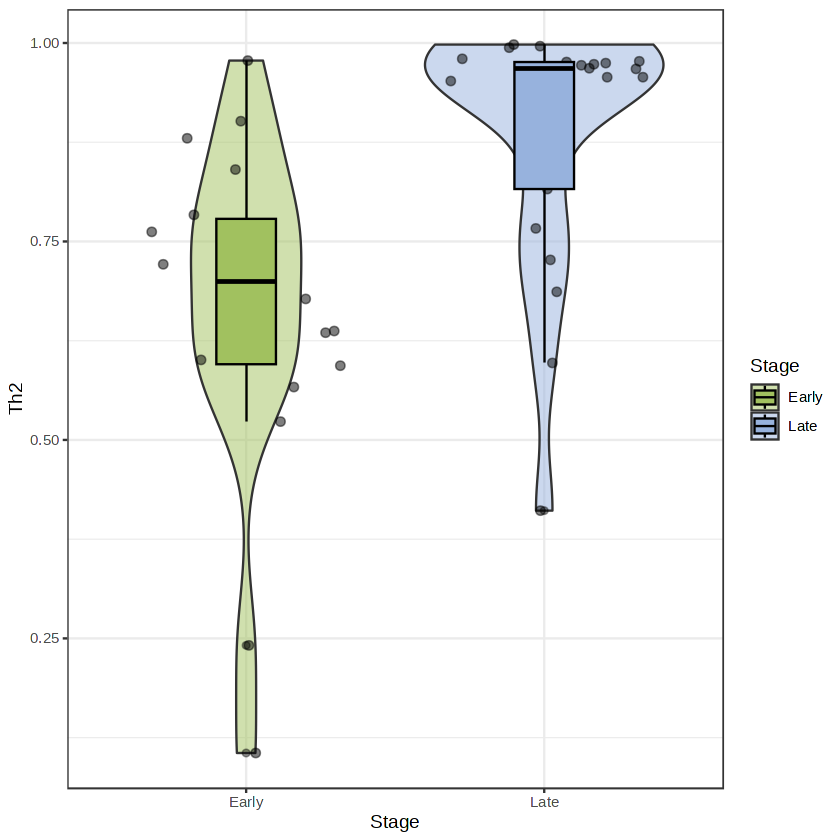

In [15]:
#pdf('./figures/Th1_Th2_Th17_boxplot.pdf',w = 4, h = 7)
set.seed(123)
ggplot(data=cc_mat_per_1, aes(x=Stage, y=Th2, fill=Stage))+
  geom_violin(width=0.8, outlier.colour = "white", outlier.size = 0.5, alpha=0.5)+
  ggbeeswarm::geom_quasirandom(method = "pseudorandom", dodge.width=0.2, size=2, shape=19, alpha=0.5) +
  scale_fill_manual(values = c("#A1C15F","#97B2DD")) +
  geom_boxplot(width=0.2,color="black",outlier.alpha = 0.4)+
  #geom_boxplot(notch=T, width=0.1, fill=NA, outlier.shape=NA, size=0.3) +
  #geom_point(aes(group=samp_loc),position=position_jitter(width = 0.1,height = 0),alpha=0.7,shape=19, color="grey60")+
  #geom_violin(width=2,color="black")+
  #geom_errorbar(data=bb, mapping = aes(x=tissue, y=mtb.median, ymin = mtb.median-mtb.sd, 
  #                                   ymax=mtb.median+mtb.sd),
  #            size=0.5, color="red",width=0)+
  #geom_point(data=bb,mapping =aes(x=tissue, y=mtb.median),
  #           size=9,color="red",shape="_") +
  #coord_cartesian(ylim = c(0,210))+
  theme_bw()
#dev.off()

In [14]:
c1 <- cc_mat_per_1$Th2[which(cc_mat_per_1$Stage == "Early")]
c2 <- cc_mat_per_1$Th2[which(cc_mat_per_1$Stage == "Late")]
wilcox.test(c1,c2)


	Wilcoxon rank sum exact test

data:  c1 and c2
W = 66, p-value = 0.0003192
alternative hypothesis: true location shift is not equal to 0
